Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median, bin_scatter = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.median(x[mask])
        if np.sum(mask)>0:
            bin_median[index] = np.median(y[mask])
            bin_scatter[index] = nmad(y[mask])
        else:
            bin_median[index], bin_scatter[index] = np.nan, np.nan
    return bin_center, bin_median, bin_scatter

def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    return ax

def plot_cutout_sizebysize(img1, img2, title1, title2, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(img1, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[0].axvline(0, ls='--', lw=0.5, color='grey')
    axes[0].axhline(0, ls='--', lw=0.5, color='grey')
    axes[0].set_title(title1)
    axes[0].set_xlabel('RA (arcsec)')
    axes[0].set_ylabel('DEC (arcsec)')
    im = axes[1].imshow(img2, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[1].axvline(0, ls='--', lw=0.5, color='grey')
    axes[1].axhline(0, ls='--', lw=0.5, color='grey')
    axes[1].set_title(title2)
    axes[1].set_xlabel('RA (arcsec)')
    axes[1].set_ylabel('DEC (arcsec)')
    # fig.colorbar(im, fraction=0.046, pad=0.04)
    return axes

In [4]:
field = 'south'
output_name = 'decals_ngc'
band = 'g'

if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_native = 0.454
else:
    pixscale_native = 0.262
# pixscale = 0.262 # pixscale for cutout queries

ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]

In [5]:
profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, output_name, band), format='ascii.commented_header')
indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, output_name, band))

profile[:3]

radius_g_10.50,flux_g_10.50,flux_scatter_g_10.50,radius_g_11.75,flux_g_11.75,flux_scatter_g_11.75,radius_g_13.00,flux_g_13.00,flux_scatter_g_13.00,radius_g_14.25,flux_g_14.25,flux_scatter_g_14.25,radius_g_15.50,flux_g_15.50,flux_scatter_g_15.50
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.763854698225,146.493606681,4.68426971828,0.763854698225,146.394984918,5.07078105876,0.763854698225,146.203129126,5.7261200756,0.667971556281,149.622109429,10.4798952242,0.763854698225,100.188589577,7.67375069711
1.58287902254,146.493552908,4.65786387587,1.49362980688,146.395069282,5.0707292587,1.58287902254,145.801101095,5.95629228893,1.66735779004,25.334453553,11.8556600633,1.58287902254,9.73879333711,2.98552012469
2.51983531208,146.240729408,4.67031703525,2.57374163427,53.4068038685,27.8617300515,2.57374163427,11.9682653738,3.49869627839,2.51983531208,3.73469775432,1.16103127316,2.51983531208,1.33127066577,0.534068294516


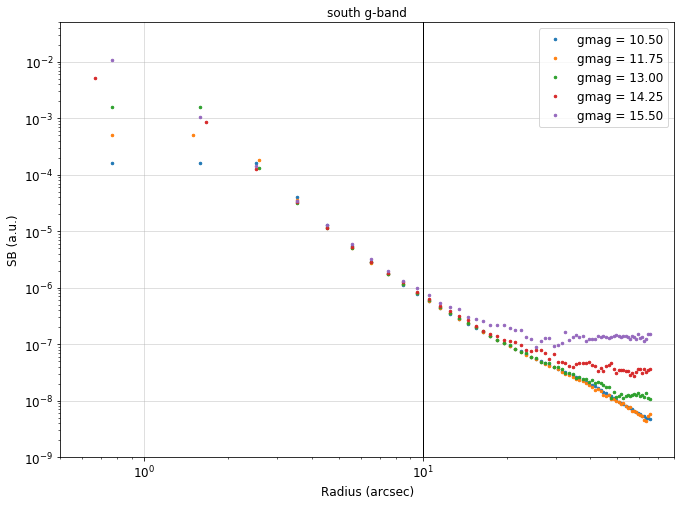

In [6]:
plt.figure(figsize=(11, 8))
for index in range(len(ls_mag_bins)):
    # normalize the flux to 22.5 magnitude stars
    norm = 10**((ls_mag_bins[index]-22.5)/2.5)
    # normalize to flux per pixel
    norm = norm * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]), c='C'+str(index))
plt.axvline(10, lw=1, color='k')
plt.title('{} {}-band'.format(field, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

__5th-order polynomial__

In [7]:
rmin, rsep, rmax = 1, 10, np.inf

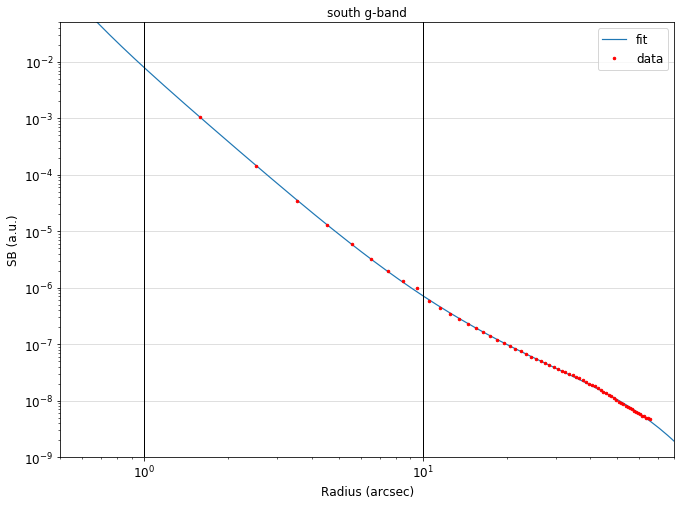

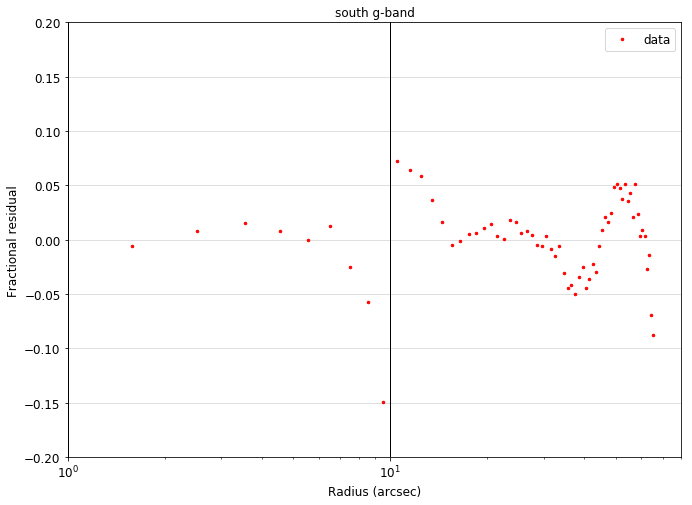

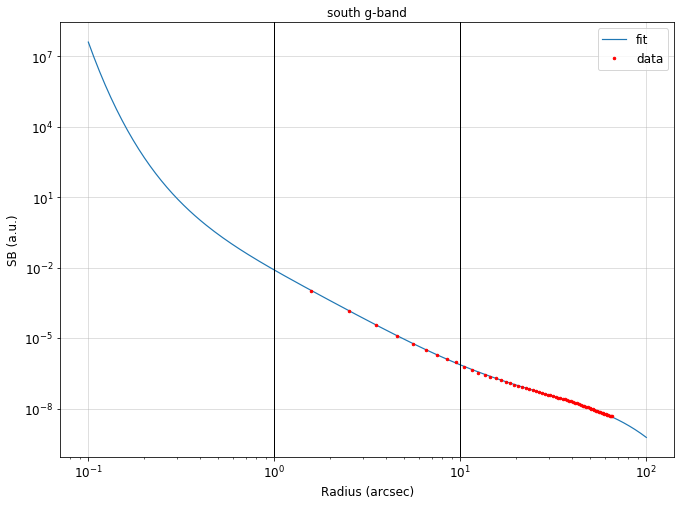

In [10]:
# stitch together the profiles of two magnitude bins
index = -1
norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
mask = (x>rmin) & (x<rsep)
xdata = x[mask]
ydata = y[mask]

index = 0
norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
mask = (x>=rsep) & (x<np.inf)
xdata = np.concatenate((xdata, x[mask]))
ydata = np.concatenate((ydata, y[mask]))

##############################################################################

xlog, ylog = np.log10(xdata), np.log10(ydata)
poly = np.polyfit(xlog, ylog, deg=5)
profile_fit = np.poly1d(poly)

# xfit = np.linspace(0.1, 300, 2000)
xfit = np.logspace(-1, 2, 200)
yfit = 10**(profile_fit(np.log10(xfit)))

plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
           label='fit', c='C0')
plt.loglog(xdata, ydata, '.', lw=1.2, alpha=1., ms=5.,
           label='data', c='r')
plt.title('{} {}-band'.format(field, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.axvline(rmin, lw=1, color='k')
plt.axvline(rsep, lw=1, color='k')
plt.legend()
plt.show()

ydata_fit = 10**(profile_fit(np.log10(xdata)))
plt.figure(figsize=(11, 8))
plt.semilogx(xdata, (ydata_fit-ydata)/ydata, '.', lw=1.2, alpha=1., ms=5.,
           label='data', c='r')
plt.title('{} {}-band'.format(field, band))
plt.axis([1, 80, -0.2, 0.2])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('Fractional residual')
plt.axvline(rmin, lw=1, color='k')
plt.axvline(rsep, lw=1, color='k')
plt.legend()
plt.show()


plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
           label='fit', c='C0')
plt.loglog(xdata, ydata, '.', lw=1.2, alpha=1., ms=5.,
           label='data', c='r')
plt.title('{} {}-band'.format(field, band))
# plt.axis([1, 80, .0002, 200])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.axvline(rmin, lw=1, color='k')
plt.axvline(rsep, lw=1, color='k')
plt.legend()
plt.show()

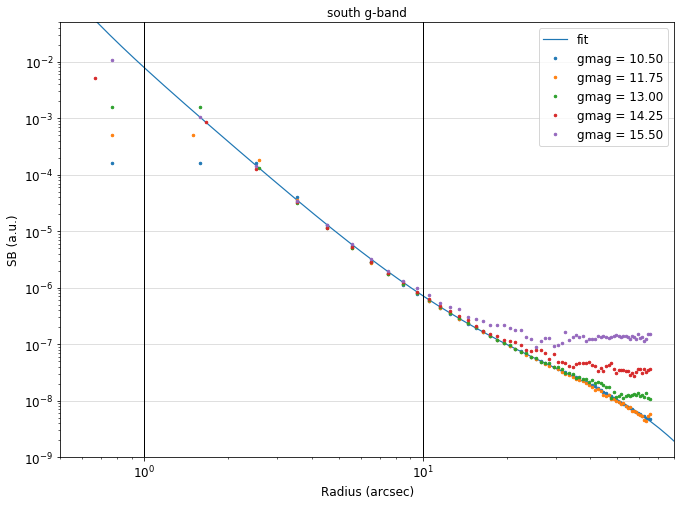

In [11]:
plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
           label='fit', c='C0')
for index in range(len(ls_mag_bins)):
    # normalize the flux to 22.5 magnitude stars
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]), c='C'+str(index))
plt.title('{} {}-band'.format(field, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.axvline(rmin, lw=1, color='k')
plt.axvline(rsep, lw=1, color='k')
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

---------

In [82]:
# ccd = fitsio.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz')
if field=='south':
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-decam-dr8.fits.gz')
elif field=='north' and band=='z':
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-mosaic-dr8.fits.gz')
elif field=='north' and (band=='g' or band=='r'):
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-90prime-dr8.fits.gz')
else:
    raise ValueError
ccd = Table(ccd)
ccd[:1]

image_filename,image_hdu,camera,expnum,plver,procdate,plprocid,ccdname,object,propid,filter,exptime,mjd_obs,airmass,fwhm,width,height,ra_bore,dec_bore,crpix1,crpix2,crval1,crval2,cd1_1,cd1_2,cd2_1,cd2_2,yshift,ra,dec,skyrms,sig1,ccdzpt,zpt,ccdraoff,ccddecoff,ccdskycounts,ccdskysb,ccdrarms,ccddecrms,ccdphrms,ccdnastrom,ccdnphotom,ccd_cuts
bytes120,int16,bytes9,int64,bytes8,bytes19,bytes7,bytes5,bytes35,bytes10,bytes1,float32,float64,float32,float32,int16,int16,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int64
decam/CPDES82/c4d_130901_031805_ooi_g_v1.fits.fz,1,decam,229341,V3.6,2015-02-13T14:01:15,87c7a6f,S29,DES survey hex -411+16 tiling 3,2012B-0001,g,90.0,56536.1375618,1.17,5.31041,2046,4094,318.359083333,0.798472222222,13422.2,6306.33,318.359091476,0.798461111032,-1.44194e-07,7.28581e-05,-7.28599e-05,-1.42286e-07,False,318.050324504,1.70306451119,0.0659636,0.00640335,24.9435,24.9554,-0.0550092,-0.0419949,1.20922,23.4952,0.073197,0.0782604,0.0229303,512,564,81920


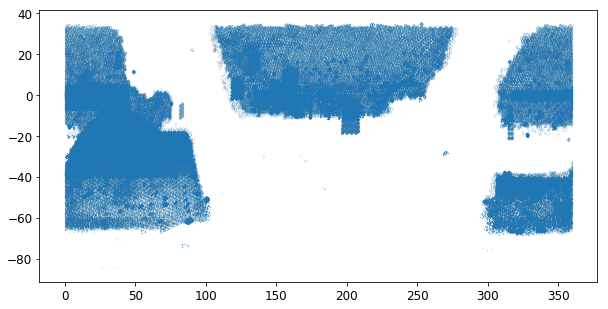

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
plt.show()

In [87]:
# dra, ddec = 1, 1
# ra, dec = 180, 0
# ra, dec = 180, 50

######################################################################

ccd_mask = ccd['filter']==band
# ccd_mask &= (ccd['ra']>ra-dra) & (ccd['ra']<ra+dra) & (ccd['dec']>dec-ddec) & (ccd['dec']<dec+ddec)
ccd_mask &= (ccd['dec']<33) & (ccd['dec']>-30)
print(np.sum(ccd_mask))

idx = np.where(ccd_mask)[0]
nplot = 20
if len(idx)>nplot:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nplot, replace=False)

1907768


281786 N9 g; FWHM = 1.04


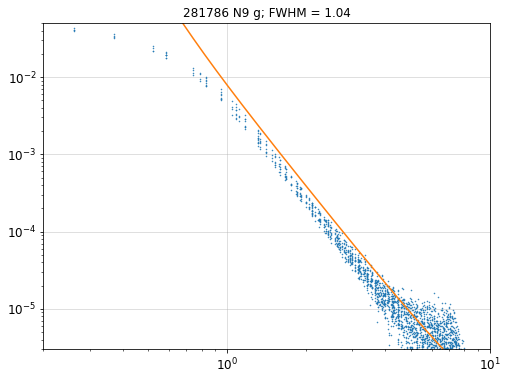

515808 S29 g; FWHM = 1.29


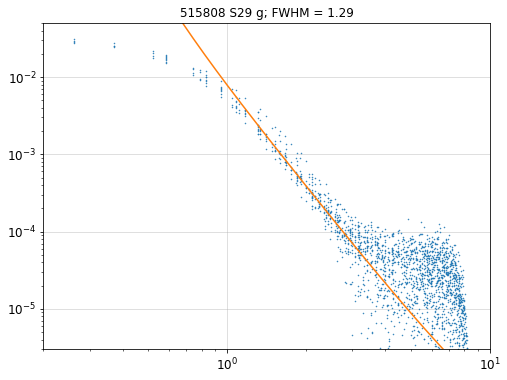

695309 N13 g; FWHM = 1.27


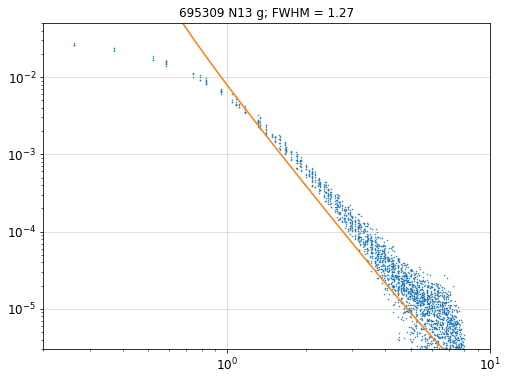

172318 S4 g; FWHM = 1.29


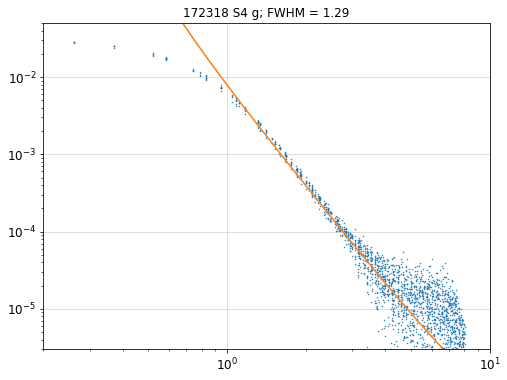

449111 N13 g; FWHM = 1.30


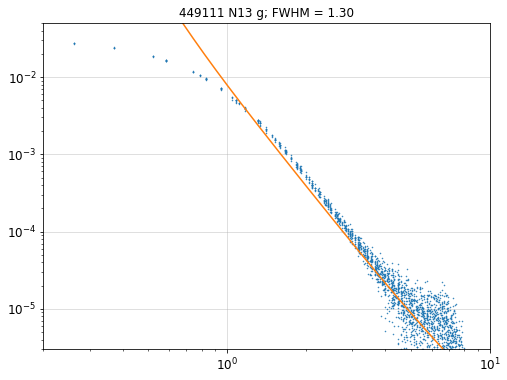

449715 S1 g; FWHM = 1.58


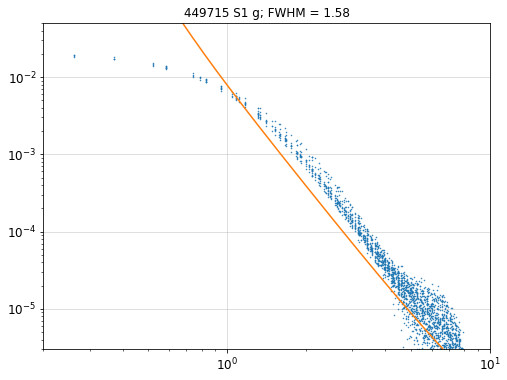

723845 N16 g; FWHM = 1.30


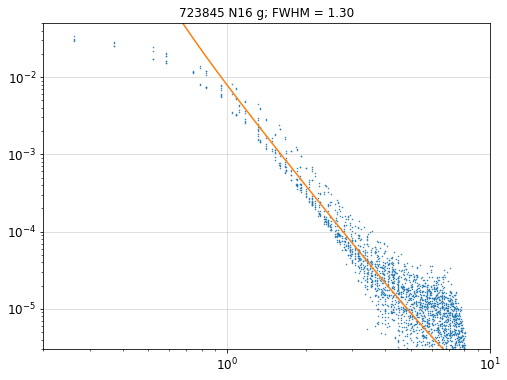

291411 S13 g; FWHM = 1.20


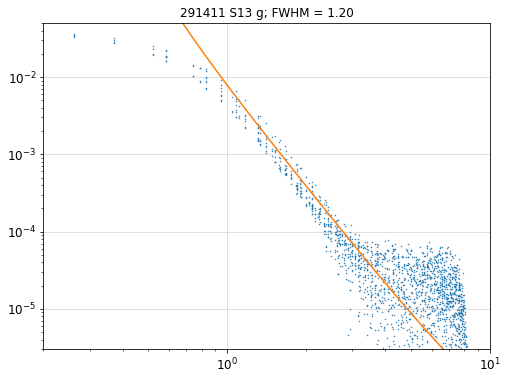

489960 N3 g; FWHM = 1.22


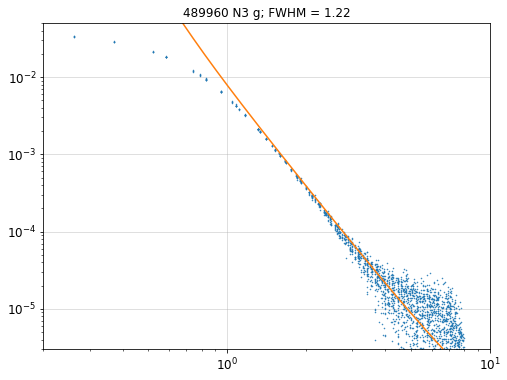

657112 N25 g; FWHM = 1.42


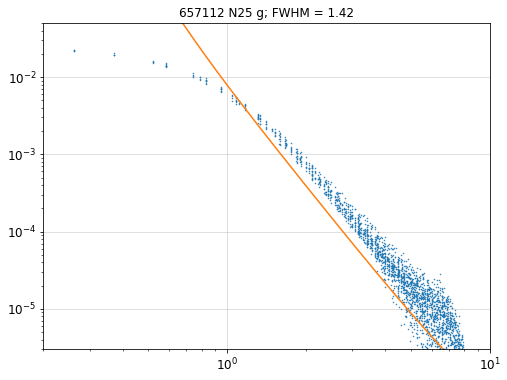

763254 S3 g; FWHM = 1.14


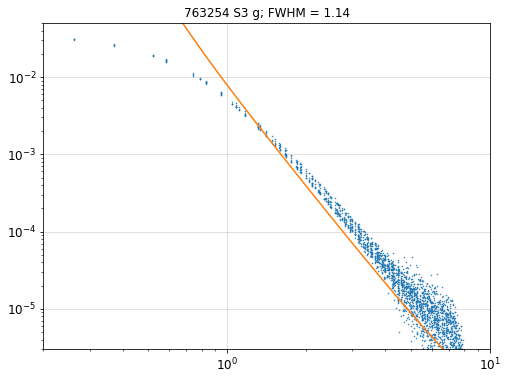

499121 S11 g; FWHM = 1.10


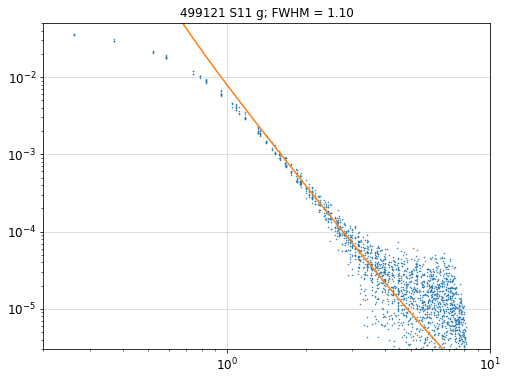

584112 S28 g; FWHM = 1.64


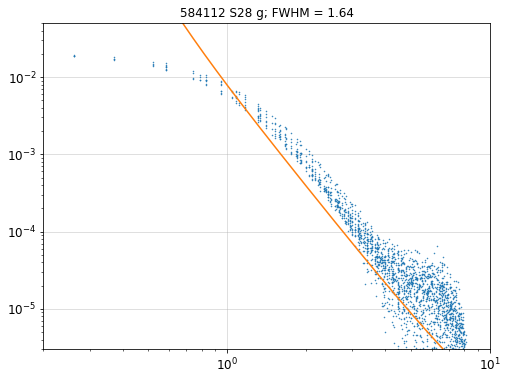

830337 N20 g; FWHM = 1.36


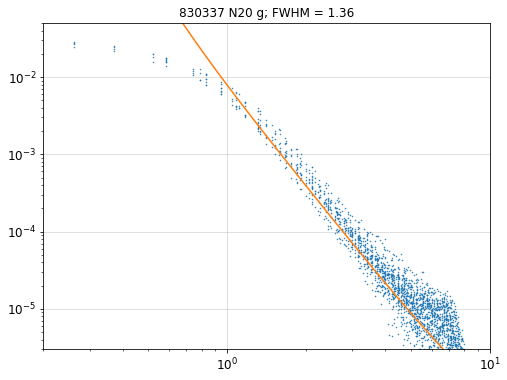

808287 N23 g; FWHM = 1.18


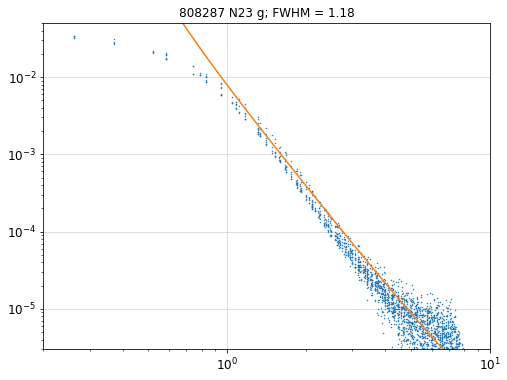

712844 N9 g; FWHM = 1.23


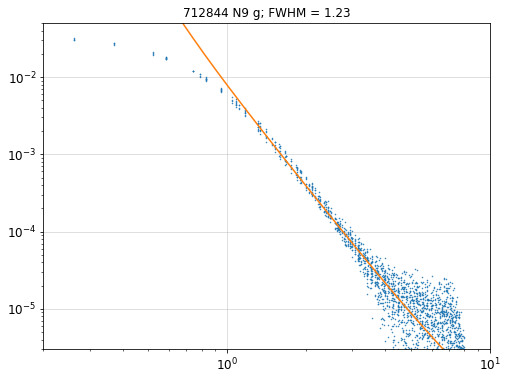

607991 S23 g; FWHM = 1.37


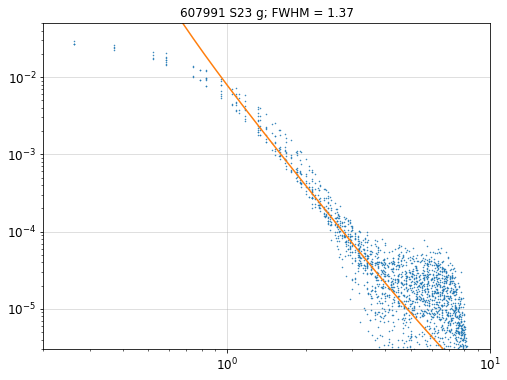

339527 N5 g; FWHM = 0.97


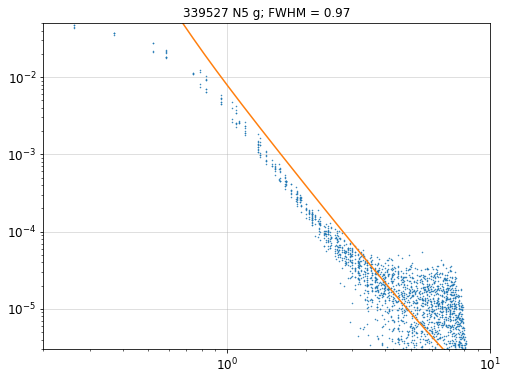

448791 S4 g; FWHM = 1.91


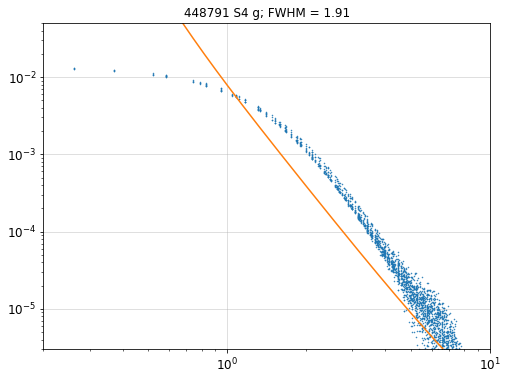

259334 S15 g; FWHM = 1.47


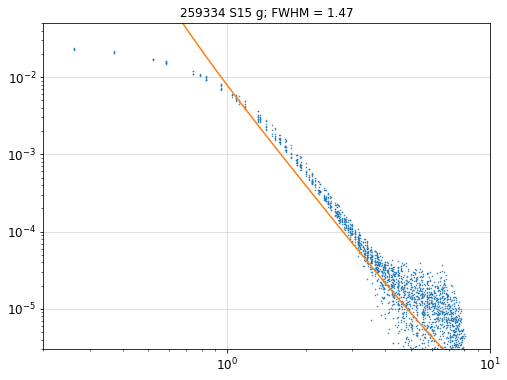

In [88]:
for ccd_index in idx:

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)
    if field=='south':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and band=='z':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/mosaic/psfex-merged/{}/mosaic-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and (band=='g' or band=='r'):
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/90prime/psfex-merged/{}/90prime-{}.fits'.format(expnum_str[:5], (8-len(expnum_str))*'0'+expnum_str)
    else:
        raise ValueError
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)

    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0

    x = np.logspace(-1, 10, 1000)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8, 6))
        plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
        plt.loglog(x, 10**(profile_fit(np.log10(x))), '-', ms=1.)
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
        plt.show()

281786 N9 g; FWHM = 1.04


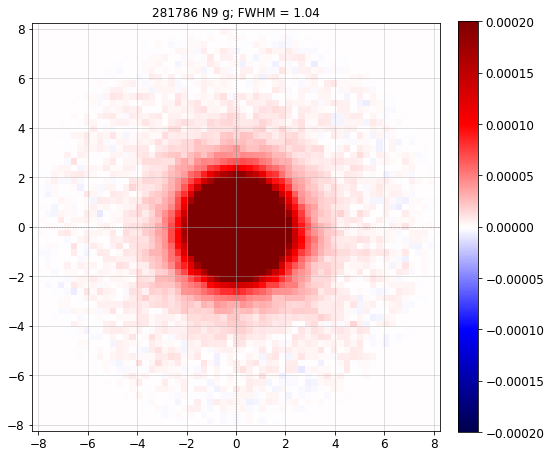

515808 S29 g; FWHM = 1.29


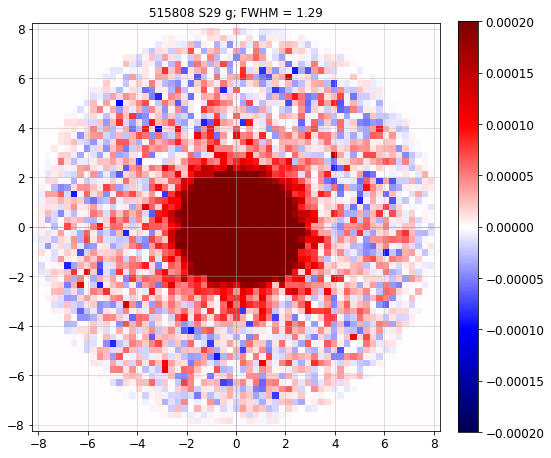

695309 N13 g; FWHM = 1.27


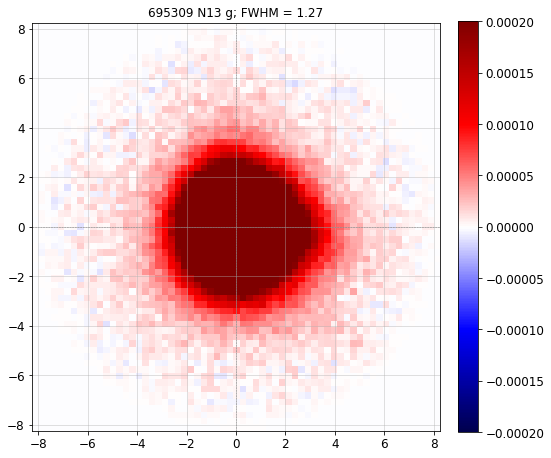

172318 S4 g; FWHM = 1.29


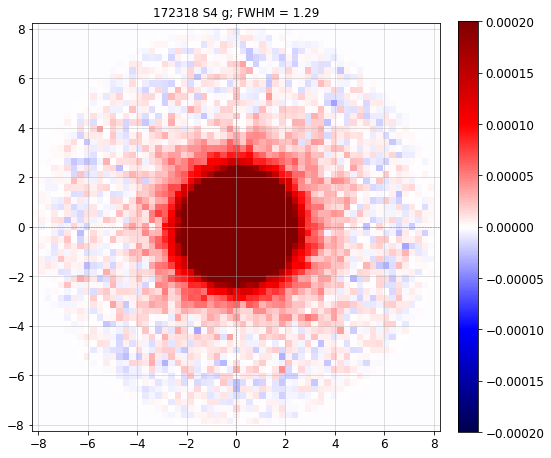

449111 N13 g; FWHM = 1.30


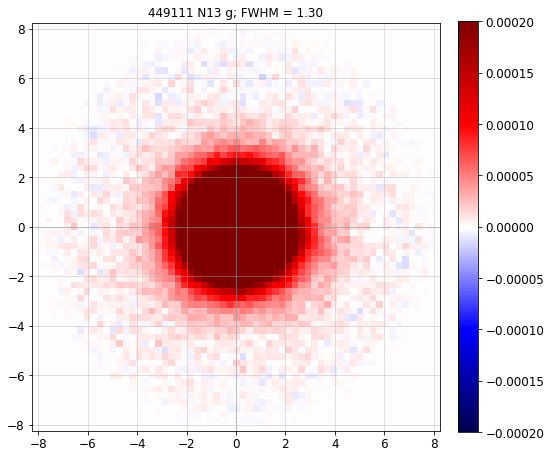

449715 S1 g; FWHM = 1.58


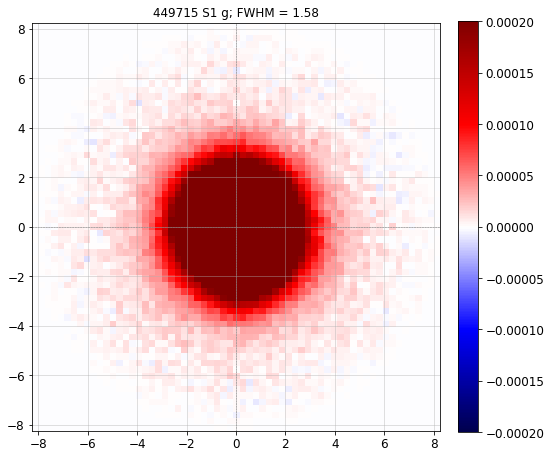

723845 N16 g; FWHM = 1.30


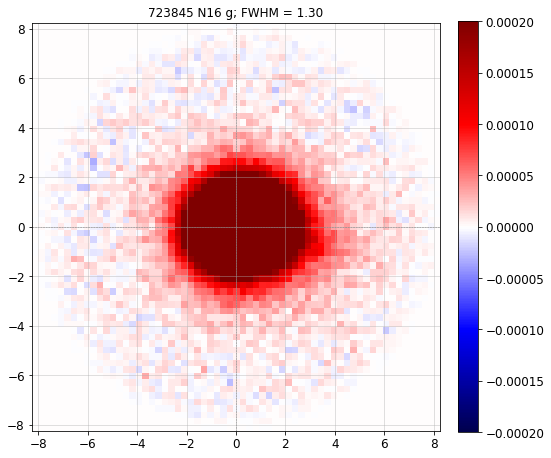

291411 S13 g; FWHM = 1.20


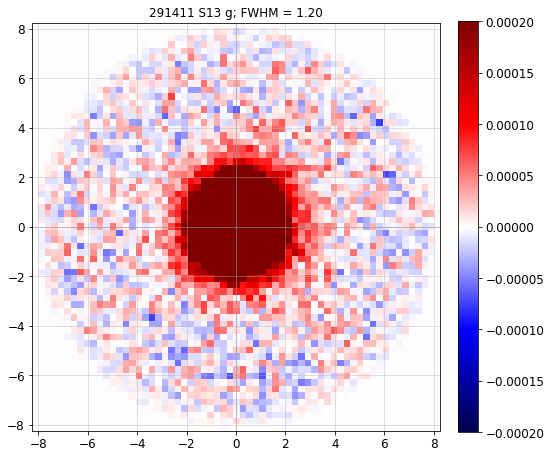

489960 N3 g; FWHM = 1.22


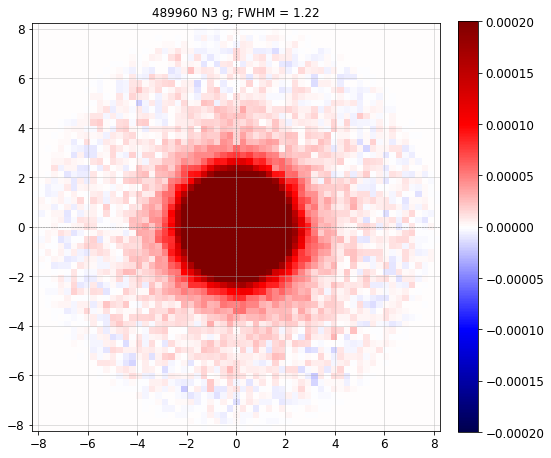

657112 N25 g; FWHM = 1.42


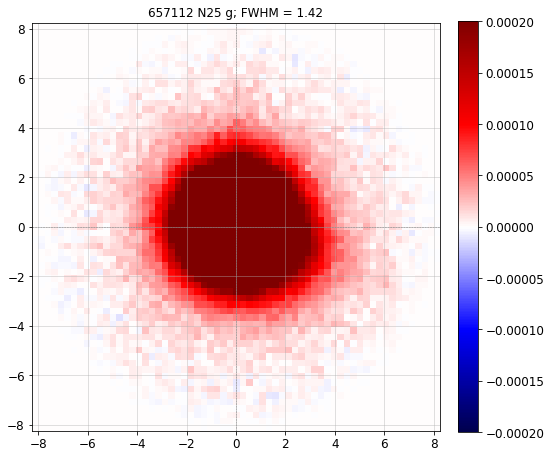

763254 S3 g; FWHM = 1.14


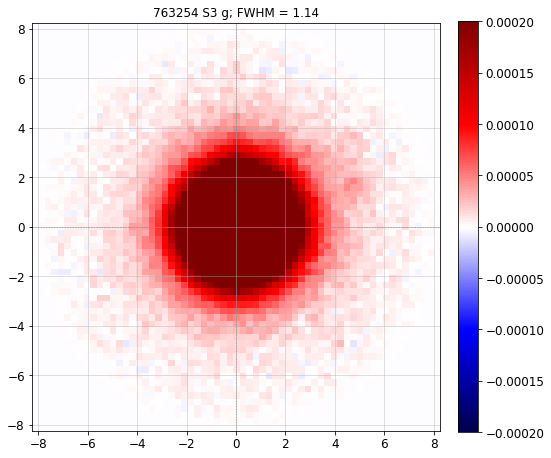

499121 S11 g; FWHM = 1.10


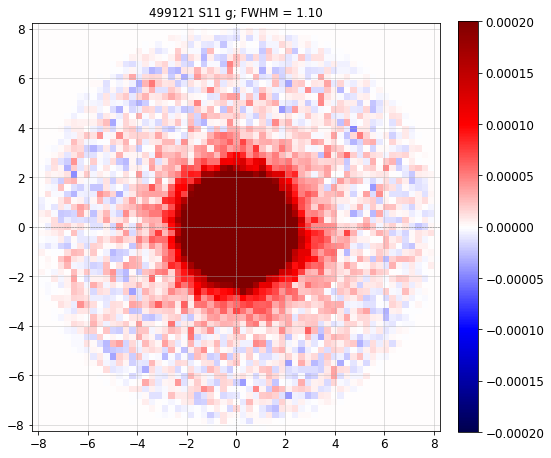

584112 S28 g; FWHM = 1.64


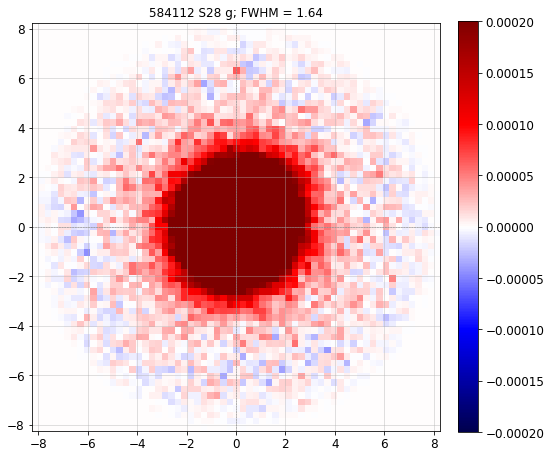

830337 N20 g; FWHM = 1.36


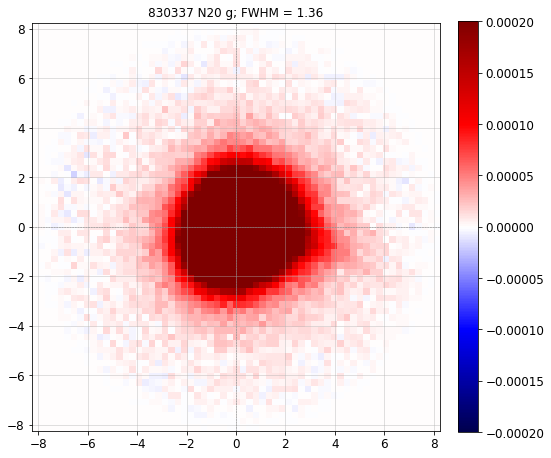

808287 N23 g; FWHM = 1.18


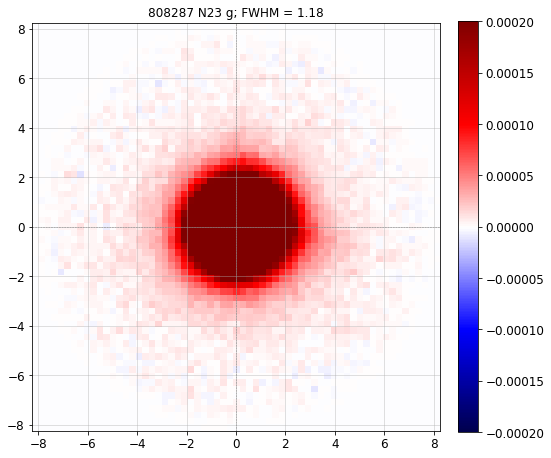

712844 N9 g; FWHM = 1.23


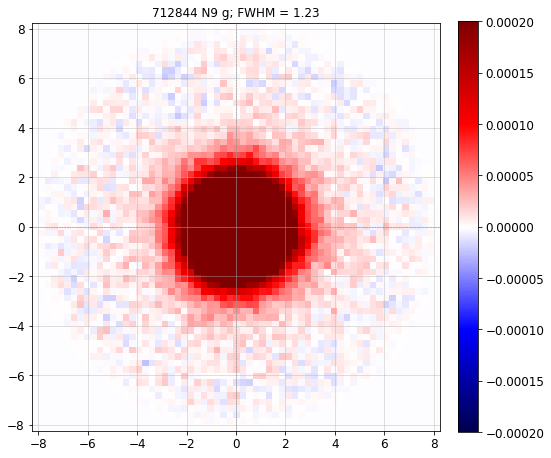

607991 S23 g; FWHM = 1.37


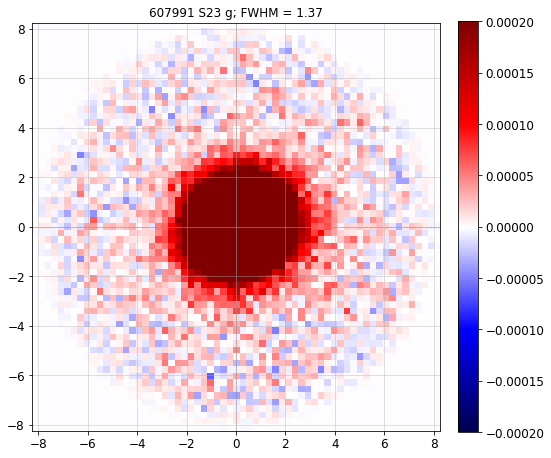

339527 N5 g; FWHM = 0.97


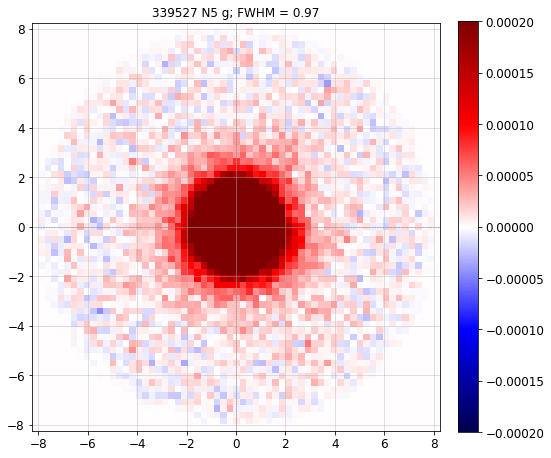

448791 S4 g; FWHM = 1.91


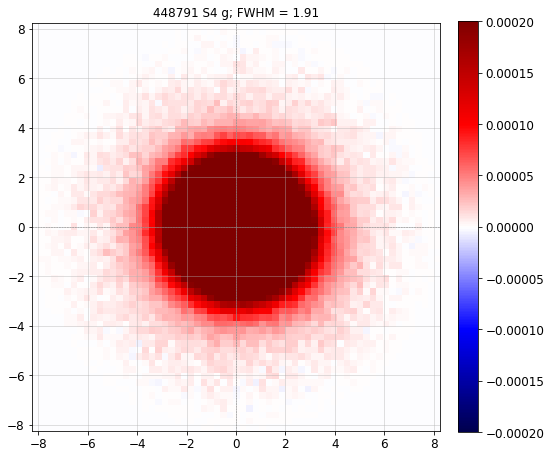

259334 S15 g; FWHM = 1.47


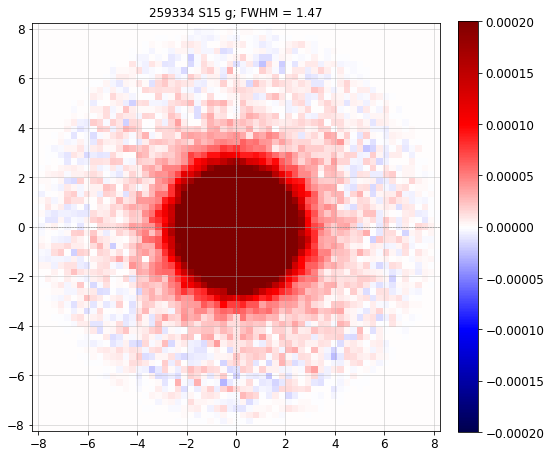

In [89]:
vrange = 0.0002
for ccd_index in idx:

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)
    if field=='south':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and band=='z':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/mosaic/psfex-merged/{}/mosaic-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and (band=='g' or band=='r'):
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/90prime/psfex-merged/{}/90prime-{}.fits'.format(expnum_str[:5], (8-len(expnum_str))*'0'+expnum_str)
    else:
        raise ValueError
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)

    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    plot_cutout(psf0, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
    plt.show()

__Make more plots__

In [90]:
idx = np.where(ccd_mask)[0]
nplot = 100
if len(idx)>nplot:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nplot, replace=False)

In [93]:
vrange = 0.0002

for ccd_index in idx:

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)
    if field=='south':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and band=='z':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/mosaic/psfex-merged/{}/mosaic-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and (band=='g' or band=='r'):
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/90prime/psfex-merged/{}/90prime-{}.fits'.format(expnum_str[:5], (8-len(expnum_str))*'0'+expnum_str)
    else:
        raise ValueError
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)

    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0

    x = np.logspace(-1, 10, 1000)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8, 6))
        plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
        plt.loglog(x, 10**(profile_fit(np.log10(x))), '-', ms=1.)
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
        plt.savefig('../plots/psfex_decam_g/{}_{}_{}_psf0_profile.png'.format(expnum, ccdname, ccd['filter'][ccd_index]))
        plt.close()
        
    plot_cutout(psf0, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
    plt.savefig('../plots/psfex_decam_g/{}_{}_{}_psf0_img.png'.format(expnum, ccdname, ccd['filter'][ccd_index]))
    plt.close()

281786 N9 g; FWHM = 1.04
515808 S29 g; FWHM = 1.29
695309 N13 g; FWHM = 1.27
172318 S4 g; FWHM = 1.29
449111 N13 g; FWHM = 1.30
449715 S1 g; FWHM = 1.58
723845 N16 g; FWHM = 1.30
291411 S13 g; FWHM = 1.20
489960 N3 g; FWHM = 1.22
657112 N25 g; FWHM = 1.42
763254 S3 g; FWHM = 1.14
499121 S11 g; FWHM = 1.10
584112 S28 g; FWHM = 1.64
830337 N20 g; FWHM = 1.36
808287 N23 g; FWHM = 1.18
712844 N9 g; FWHM = 1.23
607991 S23 g; FWHM = 1.37
339527 N5 g; FWHM = 0.97
448791 S4 g; FWHM = 1.91
259334 S15 g; FWHM = 1.47
763371 N8 g; FWHM = 1.39
482810 N26 g; FWHM = 1.58
659946 S7 g; FWHM = 1.71
563623 N18 g; FWHM = 0.94
229686 S24 g; FWHM = 1.75
686106 S26 g; FWHM = 1.74
281330 N27 g; FWHM = 1.27
212366 N15 g; FWHM = 1.87
634557 N2 g; FWHM = 1.40
656736 N7 g; FWHM = 1.48
779846 S10 g; FWHM = 1.45
769011 S3 g; FWHM = 1.18
388503 N16 g; FWHM = 0.99
389465 S15 g; FWHM = 0.96
598348 S26 g; FWHM = 1.22
382610 N12 g; FWHM = 1.79
568774 S20 g; FWHM = 1.42
605613 S6 g; FWHM = 1.09
283537 S5 g; FWHM = 1.39
3